In [13]:
import sys
import pylab as pl
sys.path.insert(0, '..')

import pymoca.parser
import pymoca.backends.sympy.generator as generator
import pylab as pl
import sympy
import control
sympy.init_printing()

%matplotlib inline

# Modelica Source Code

In [14]:
modelica_src = '''

model System
    input Real u;
    output Real x(start=1), v_x(start=1);
    Spring spring;
    Damper damper;
equation
    spring.x = x;
    damper.v = v_x;
    der(x) = v_x;
    der(v_x) = spring.f + damper.f - u;
end System;

model Spring
    Real x "displacement";
    Real f "force";
    parameter Real k = 2.0 "spring constant";
equation
    f = -k*x;
end Spring;

model Damper
    Real v "velocity";
    Real f "force";
    parameter Real c = 0.2 "damping constant";
equation
    f = -c*v;
end Damper;
'''

# Generation of Abstract Syntax Tree

In [15]:
ast = pymoca.parser.parse(modelica_src)
ast.classes['System'].symbols.keys()

odict_keys(['u', 'x', 'v_x', 'spring', 'damper'])

In [16]:
ast

Tree(classes=OrderedDict([('System', Class(type='model', name='System')), ('Spring', Class(type='model', name='Spring')), ('Damper', Class(type='model', name='Damper'))]))

# Generation of Sympy Model

In [17]:
src_code = generator.generate(ast, 'System')
print(src_code)


# do not edit, generated by pymoca

from __future__ import print_function, division
import sympy
import sympy.physics.mechanics as mech
from pymoca.backends.sympy.runtime import OdeModel
from sympy import sin, cos, tan


class System(OdeModel):

    def __init__(self):

        super(System, self).__init__()

        # states
        x, v_x = mech.dynamicsymbols('x, v_x')
        self.x = sympy.Matrix([x, v_x])
        self.x0 = {
            x : 1,
            v_x : 1,
            }

        # variables
        spring__x, spring__f, damper__v, damper__f = mech.dynamicsymbols('spring.x, spring.f, damper.v, damper.f')
        self.v = sympy.Matrix([spring__x, spring__f, damper__v, damper__f])

        # constants
        self.c = sympy.Matrix([])
        self.c0 = {
            }

        # parameters
        spring__k, damper__c = sympy.symbols('spring.k, damper.c')
        self.p = sympy.Matrix([spring__k, damper__c])
        self.p0 = {
            spring__k : 2.0,
            dampe

In [18]:
exec(src_code)
model = System()
model

{'t': t, 'x': Matrix([
[  x(t)],
[v_x(t)]]), 'u': Matrix([[u(t)]]), 'y': Matrix([
[  x(t)],
[v_x(t)]]), 'p': Matrix([
[spring.k],
[damper.c]]), 'c': Matrix(0, 0, []), 'v': Matrix([
[spring.x(t)],
[spring.f(t)],
[damper.v(t)],
[damper.f(t)]]), 'x0': {x(t): 1, v_x(t): 1}, 'u0': {u(t): 0.0}, 'p0': {spring.k: 2.0, damper.c: 0.2}, 'c0': {}, 'eqs': [spring.k*spring.x(t) + spring.f(t), damper.c*damper.v(t) + damper.f(t), spring.x(t) - x(t), damper.v(t) - v_x(t), -v_x(t) + Derivative(x(t), t), -damper.f(t) - spring.f(t) + u(t) + Derivative(v_x(t), t)], 'f': Matrix([
[                                 v_x(t)],
[-damper.c*v_x(t) - spring.k*x(t) - u(t)]]), 'g': Matrix([
[  x(t)],
[v_x(t)]])}

In [19]:
t = sympy.Symbol('t')
model.x.diff(t)

⎡d        ⎤
⎢──(x(t)) ⎥
⎢dt       ⎥
⎢         ⎥
⎢d        ⎥
⎢──(vₓ(t))⎥
⎣dt       ⎦

In [20]:
sol = sympy.solve(model.eqs, list(model.v) + list(model.x.diff(t)))
sol

In [21]:
model.x.diff(t).subs(sol)

⎡                vₓ(t)                 ⎤
⎢                                      ⎥
⎣-damper.c⋅vₓ(t) - spring.k⋅x(t) - u(t)⎦

In [22]:
model.linearize_symbolic()

⎡⎡    0          1    ⎤  ⎡0 ⎤  ⎡1  0⎤  ⎡0⎤⎤
⎢⎢                    ⎥, ⎢  ⎥, ⎢    ⎥, ⎢ ⎥⎥
⎣⎣-spring.k  -damper.c⎦  ⎣-1⎦  ⎣0  1⎦  ⎣0⎦⎦

In [23]:
ss = control.ss(*model.linearize())
ss

<LinearIOSystem:sys[3]:['u[0]']->['y[0]', 'y[1]']>

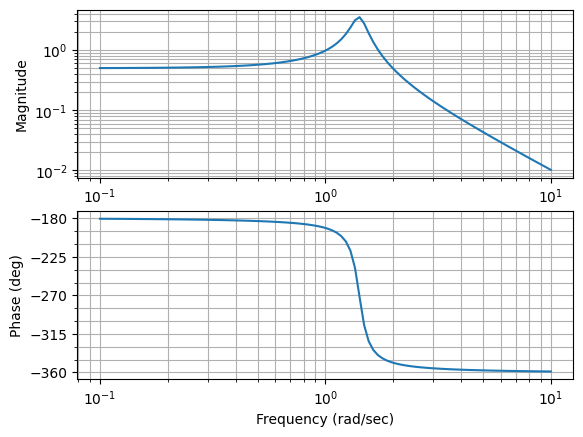

In [24]:
control.bode(ss[0,0], omega=pl.logspace(-1,1,100));

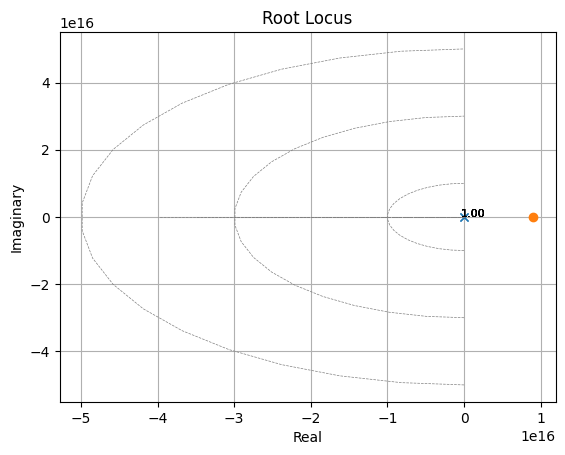

In [25]:
control.rlocus(ss[0,0], kvect=pl.logspace(-2,1,1000));
pl.grid()

# Simulation of Sympy Model

In [26]:
model.f

⎡                vₓ(t)                 ⎤
⎢                                      ⎥
⎣-damper.c⋅vₓ(t) - spring.k⋅x(t) - u(t)⎦

In [27]:
import sympy
ss_sub = {}
ss_sub.update({model.x[i]: sympy.DeferredVector('x')[i] for i in range(len(model.x))})
#ss_sub.update({model.y[i]: sympy.DeferredVector('y')[i] for i in range(len(model.y))})
ss_sub

In [28]:
res = model.simulate(t0=10, tf=20, dt=0.001)

Text(0, 0.5, 'x')

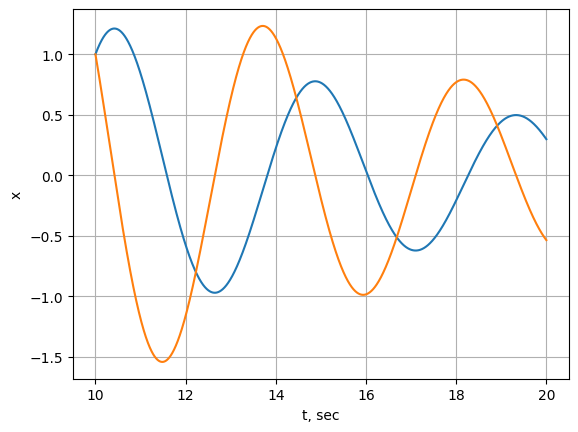

In [29]:
pl.plot(res['t'], res['x'])
pl.grid()
pl.xlabel('t, sec')
pl.ylabel('x')

In [30]:
sympy.init_printing()
model.f

⎡                vₓ(t)                 ⎤
⎢                                      ⎥
⎣-damper.c⋅vₓ(t) - spring.k⋅x(t) - u(t)⎦

In [31]:
model.f.jacobian(model.x)

⎡    0          1    ⎤
⎢                    ⎥
⎣-spring.k  -damper.c⎦

# Lyapunov Stability

Using the energy function as a candidate function, we can show that the system has global exponential stability (GES).

In [32]:
v_x = sympy.Function('v_x')
x = sympy.Function('x')
V = sympy.Function('V')
spring_k, t = sympy.symbols('spring.k, t')
V_eq = (v_x(t)**2 + spring_k*x(t)**2)/2
sympy.Eq(V(t), V_eq)

In [33]:
dV_dt_eq = (sympy.Matrix([V_eq]).jacobian(model.x).dot(model.f)).simplify()
sympy.Eq(V(t).diff(t), dV_dt_eq)

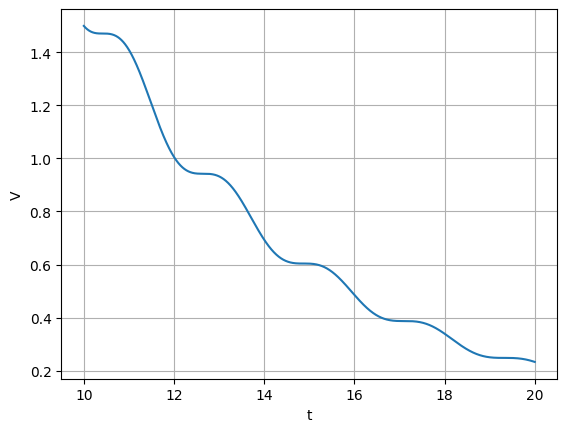

In [34]:
V_lam = sympy.lambdify(model.x, V_eq.subs(model.p0))
V_vals = [V_lam(*x) for x in res['x']]
pl.plot(res['t'], V_vals)
pl.xlabel('t')
pl.ylabel('V')
pl.grid()

# Parameter Sensitivity

In [35]:
model.f.jacobian(model.p)

⎡  0      0   ⎤
⎢             ⎥
⎣-x(t)  -vₓ(t)⎦